In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [0]:
PI_STAR = "\u03C0"+"*"
HAT = "\u0302"

###Part1

####Q4


In [0]:
''' One Iteration of Value-Iteration Algorithm
  params
  ------
  v_mapping (Pandas DataFrame):
    df of states as idx and (at least) one column of "v_t".
    it assigns current values to each state.

  s (str):
    the current state whose value we want to calculate.
  
  a (str):
    one action from the actions set represent the candidate to bring
    the optimal value from the current state.

  reward_function (function): 
    gets a tuple (s=state, a=action) and returns a real number (reward).
  
  actions_matrices_dict (Dict): 
    dict with actions as keys and their mappings as pd.DataFrame s.t 
    index and cols are the MDS states, and entries are the probablity
    to transmit from the state in the col (s) to the state in the row (s_tag).
'''

def update_value(v_mapping, s, a, reward_function , actions_matrices_dict, gamma=0.5):
  states = v_mapping.index
  left_side = reward_function(s,a)
  right_side = 0
  for s_tag in states:
    right_side += actions_matrices_dict[a].loc[s_tag, s]*v_mapping.loc[s_tag,"v_t"]
  return left_side + right_side


''' Estimate an Optimal Policy to a Given MDS Problem
  params
  ------
  actions_matrices_dict (Dict):
    dict with actions as keys and their mappings as pd.DataFrame s.t 
    index and cols are the MDS states, and entries are the probablity 
    to transmit from the state in the col (s) to the state in the row (s_tag).
  
  reward_function (function):
    function which maps from a tuple (s=state, a=action) to a real number reward.
  
  init_v_mapping (Pandas DataFrame):
    df of states as idx and (at least) one column of "v_t". 
    it assigns an initial value in time t for each state s.
'''

def value_iteration(actions_matrices_dict, reward_function, init_v_mapping, gamma=0.5, epsilon=np.exp(-10), T_max=5000):
  
  actions = list(actions_matrices_dict.keys())
  v_mapping = init_v_mapping.copy()
  # while loop's indicators
  prev_opt_value = v_mapping["v_t"]
  opt_value = np.repeat(np.inf,init_v_mapping.shape[0])
  t=0

  while ((opt_value - prev_opt_value) > epsilon).any() and (t<T_max):
    # apply the updating rule of Value Iteration
    # vectorization to get rid of loop over states
    for a in actions:
      v_mapping[a] = v_mapping.apply(lambda row: \
          update_value(v_mapping, row.name, a, reward_function , actions_matrices_dict, gamma), axis=1)
    
    # update df and while loop's indicators with results
    opt_value = v_mapping[actions].max(axis=1)
    v_mapping["policy"] = v_mapping[actions].idxmax(axis=1)
    prev_opt_value = v_mapping["v_t"]
    v_mapping["v_t"] = opt_value
    t+=1

  return v_mapping

Setting our "Home-Out" MDS problem

In [0]:
init_v_mapping = pd.DataFrame(0, index=list("HO"), columns=["v_t"])

def reward_home_out(s,a):
  if s=="H":
    if a=="STAY":
      return 0
    elif a== "SWITCH":
      # s_next = np.random.choice(["H","O"], p=[0.2,0.8])
      return 1
    else:
      print(a+" is not an action in this MDS")
      return False
  elif s=="O":
    if a=="STAY":
      return 2
    elif a== "SWITCH":
      return 0
    else:
      print(a+" is not an action in this MDS")
      return False
  else:
    print(s+" is not a state in this MDS")
    return False

actions_matrices_home_out={
"STAY" : pd.DataFrame(np.array([[1,0],[0,1]]), index=list("HO"), columns=list("HO")),
"SWITCH" : pd.DataFrame(np.array([[0.2,1],[0.8,0]]), index=list("HO"), columns=list("HO"))
}

The optimal value and policy found by the Value-Iteration algorithm are:

In [46]:
result = value_iteration(actions_matrices_dict=actions_matrices_home_out,reward_function=reward_home_out, init_v_mapping=init_v_mapping)
result[["v_t","policy"]].rename(columns={"v_t":"v*", "policy":PI_STAR})

,v*,π*
H,2.8,SWITCH
O,4.0,STAY


The optimal policy is the same as we found in Question 2. Yet, the optimal value isn't what we found in the analytic part, but it depends on the arbitrary initial value we assigned to the states in the algorithm.

###Part2

####Q1

We can use the "Home-Out" setting from the previous part when we build this function

In [0]:
def get_next_s(s,a, reward_function, actions_matrices_dict):
  s_next = np.random.choice(actions_matrices_dict[a][s].index, p=actions_matrices_dict[a][s].values)
  r = reward_function(s,a)
  return s_next, r

####Q2

In [0]:
ETA = 0.01
GAMMA = 0.5
T = 3000
s = "H" # initialization
v_map = init_v_mapping.rename(columns={"v_t":0}) # initialization
actions = ["STAY","SWITCH"]

for t in range(1,T+1):
  v_map[t] = np.nan
  act = np.random.choice(actions, p=[0.5,0.5]) # not depended by the states
  s_tag, r = get_next_s(s,act, reward_home_out, actions_matrices_home_out)
  
  # update by TD-error (asynchronic)
  v_map.loc[s,t] = v_map.loc[s,t-1] + ETA*\
  (reward_home_out(s,act) + GAMMA*v_map.loc[s_tag,t-1] - v_map.loc[s,t-1])
  
  # fill the other s accordingly
  if s_tag != s:
    v_map.loc[s_tag,t] = v_map.loc[s_tag,t-1]
    s = s_tag
  else:
    other_s = v_map.index.difference(pd.Index([s]))[0]
    v_map.loc[other_s,t] = v_map.loc[other_s,t-1]

In [0]:
v_map.transpose()

,H,O
0,0.000000,0.000000
1,0.010000,0.000000
2,0.010000,0.020000
3,0.010000,0.019850
4,0.019999,0.019850
...,...,...
2996,1.224793,1.733822
2997,1.218669,1.733822
2998,1.225151,1.733822
2999,1.225151,1.745152


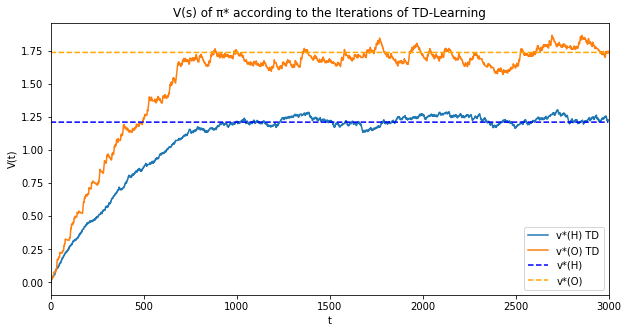

In [0]:
v_map.transpose().rename(columns={"H":'v*(H) TD',"O":'v*(O) TD'}).plot(figsize=(10,5))
plt.title("V(s) of "+PI_STAR+" according to the Iterations of TD-Learning")
plt.xlabel("t")
plt.ylabel("V(t)")
plt.plot(np.arange(3000), np.repeat(1.21,3000), linestyle="--", label='v*(H)', c="b")
plt.plot(np.arange(3000), np.repeat(1.736,3000), linestyle="--", label='v*(O)', c="orange")
plt.legend()
plt.show()

The learning converges to the true optimal values. We can be impressed by the convergence from approximately t=800.\
Increasing the learning rate (ETA) causes the algo to converge faster, but also to an higher variability around the truth value after convergence. On the other hand, lower ETA's cause the algo to converge slower but decrease the variablity around the truth value after convergence has achieved.

####Q3

In [0]:
ETA = 0.1
T = 3000
GAMMA = 0.5
states = ["H","O"]
actions = ["STAY","SWITCH"]
Q = pd.DataFrame(0,index=["H_STAY","H_SWITCH","O_STAY","O_SWITCH"], columns=[0]) # initialization
V_s = pd.DataFrame(np.nan, index=np.arange(1,T+1), columns=states).rename_axis(index="t") # initialization

for t in range(1,T+1):
  # act = np.random.choice(actions, p=[0.5,0.5]) # not depended by the states
  # H
  Q[t] = np.nan
  # update every Q(s,a)
  for s in states:
    for a in actions:
      s_tag, r = get_next_s(s,a, reward_home_out, actions_matrices_home_out)
      delta = r + GAMMA*Q.loc[Q.index.str.startswith(s_tag),t-1].max() - Q.loc[s+"_"+a,t-1]
      # updating rule
      Q.loc[s+"_"+a,t] = Q.loc[s+"_"+a,t-1] + ETA*delta
    # apply max over optional actions
    V_s.loc[t,s] = Q.loc[Q.index.str.startswith(s),t].max()

In [40]:
V_s

,H,O
t,,
1,0.100000,0.200000
2,0.195000,0.390000
3,0.295000,0.570500
4,0.394025,0.741975
5,0.491721,0.904876
...,...,...
2996,2.810949,4.000000
2997,2.829854,4.000000
2998,2.846869,4.000000


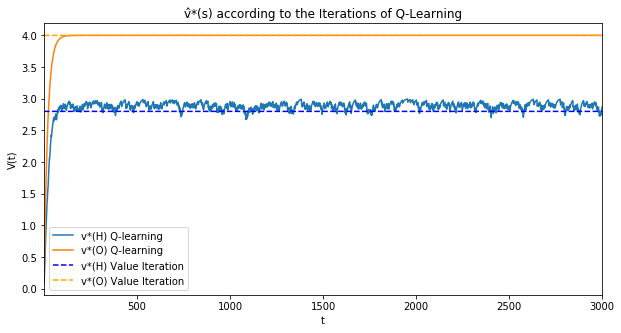

In [49]:
V_s.rename(columns={"H":'v*(H) Q-learning',"O":'v*(O) Q-learning'}).plot(figsize=(10,5))
plt.title("V"+HAT+"*(s) according to the Iterations of Q-Learning")
plt.xlabel("t")
plt.ylabel("V(t)")
plt.plot(np.arange(3000), np.repeat(result.loc["H","v_t"],3000), linestyle="--", label='v*(H) Value Iteration', c="b")
plt.plot(np.arange(3000), np.repeat(result.loc["O","v_t"],3000), linestyle="--", label='v*(O) Value Iteration', c="orange")
plt.legend()
plt.show()

The values converged to their optimal values as they have been computed in Part a Question 4. By the optimal values we can infer the optimal policy easly using the Bellman Optimality Equation, as all of the other parameters are known and we just have to maximize over the set of actions.\
Note that the variability after convergence of V(O) is 0 yet v(h) do have few variability. The reason may be the differneces between the transition probabilities of the two states: given a specific action the transition from state 'Out' is determined, while there is some randomness in the transition from state 'Home' given the action 'Switch'.